# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [13]:
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 250         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic 2539
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Actor and critic models**

In [18]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=200, fc2_units=150):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=200, fc2_units=150):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear((state_size+action_size) * num_agents, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, action):
        xs = torch.cat((state, action), dim=1)
        x = F.relu(self.fcs1(xs))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

**Noise and Replay Buffer**

In [19]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()  
        
    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["states", "actions", "rewards", "next_states", "dones"])
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states_list = [torch.from_numpy(np.vstack([e.states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        actions_list = [torch.from_numpy(np.vstack([e.actions[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]
        next_states_list = [torch.from_numpy(np.vstack([e.next_states[index] for e in experiences if e is not None])).float().to(device) for index in range(num_agents)]            
        rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)        
        dones = torch.from_numpy(np.vstack([e.dones for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states_list, actions_list, rewards, next_states_list, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [20]:
sharedBuffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

**DDPG Agent**

In [21]:
class DDPGAgent():
    
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        
        # Construct Actor networks
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),lr=LR_ACTOR)

        # Construct Critic networks 
        self.critic_local = Critic(state_size, action_size , random_seed).to(device)
        self.critic_target = Critic(state_size, action_size , random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # noise processing
        self.noise = OUNoise(action_size, random_seed)
            
    def step(self):
        if len(sharedBuffer) > BATCH_SIZE:
            experiences = sharedBuffer.sample()
            self.learn(experiences, GAMMA)        

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states_list, actions_list, rewards, next_states_list, dones = experiences
                    
        next_states_tensor = torch.cat(next_states_list, dim=1).to(device)
        states_tensor = torch.cat(states_list, dim=1).to(device)
        actions_tensor = torch.cat(actions_list, dim=1).to(device)
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        next_actions = [self.actor_target(states) for states in states_list]        
        next_actions_tensor = torch.cat(next_actions, dim=1).to(device)        
        Q_targets_next = self.critic_target(next_states_tensor, next_actions_tensor)        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))        
        # Compute critic loss
        Q_expected = self.critic_local(states_tensor, actions_tensor)
        critic_loss = F.mse_loss(Q_expected, Q_targets)        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        # take the current states and predict actions
        actions_pred = [self.actor_local(states) for states in states_list]        
        actions_pred_tensor = torch.cat(actions_pred, dim=1).to(device)
        # -1 * (maximize) Q value for the current prediction
        actor_loss = -self.critic_local(states_tensor, actions_pred_tensor).mean()        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()        
        #torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

**MDDPG**

In [22]:
class MADDPG:

    def __init__(self, random_seed):
        self.agents = [DDPGAgent(state_size,action_size,random_seed) for x in range(num_agents)]

    def step(self, states, actions, rewards, next_states, dones):
        sharedBuffer.add(states, actions, rewards, next_states, dones)

        for agent in self.agents:
            agent.step()

    def act(self, states, add_noise=True):
        actions = np.zeros([num_agents, action_size])
        for index, agent in enumerate(self.agents):
            actions[index, :] = agent.act(states[index], add_noise)
        return actions

    def save_weights(self):
        for index, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(), 'agent{}_checkpoint_actor.pth'.format(index+1))
            torch.save(agent.critic_local.state_dict(), 'agent{}_checkpoint_critic.pth'.format(index+1))
    
    def reset(self):        
        for agent in self.agents:
            agent.reset()

In [23]:
maddpgagent = MADDPG(0)

**Train using MDDPG**

In [24]:
def train_mddpg(n_episodes=5000):
    scores_deque = deque(maxlen=100)
    scores = []
    average_scores_list = []

    for i_episode in range(1, n_episodes+1):                                    
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations               
        score = np.zeros(num_agents)

        maddpgagent.reset()

        while True:
            actions = maddpgagent.act(states)
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations
            rewards = env_info.rewards         
            dones = env_info.local_done                         
            maddpgagent.step(states, actions, rewards, next_states, dones)        
            states = next_states
            score += rewards  

            if any(dones):                                 
                break

        score_max = np.max(score)
        scores.append(score_max)
        scores_deque.append(score_max)
        average_score = np.mean(scores_deque)
        average_scores_list.append(average_score)

        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)), end="")  

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage score: {:.3f}'.format(i_episode , average_score))

        if average_score >= 0.5:
            maddpgagent.save_weights()
            print("\rSolved in episode: {} \tAverage score: {:.3f}".format(i_episode , average_score))
            break
    return scores , average_scores_list

In [25]:
scores , average_scores_list = train_mddpg()

Episode 100	Average score: 0.010
Episode 200	Average score: 0.000
Episode 300	Average score: 0.002
Episode 400	Average score: 0.021
Episode 500	Average score: 0.004
Episode 600	Average score: 0.021
Episode 700	Average score: 0.029
Episode 800	Average score: 0.072
Episode 900	Average score: 0.101
Episode 1000	Average score: 0.124
Episode 1100	Average score: 0.130
Episode 1200	Average score: 0.184
Episode 1300	Average score: 0.306
Episode 1400	Average score: 0.400
Episode 1500	Average score: 0.344
Solved in episode: 1563 	Average score: 0.502


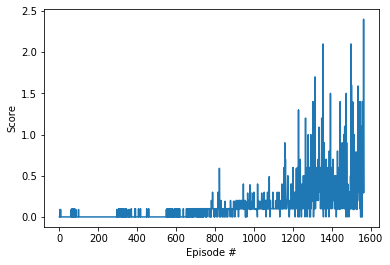

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

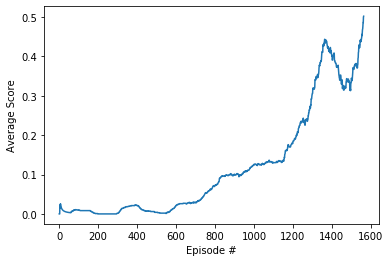

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores_list)+1), average_scores_list)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

In [28]:
env.close()